# Kinematic Car

kinematic model of a car

In [1]:
import logging
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np

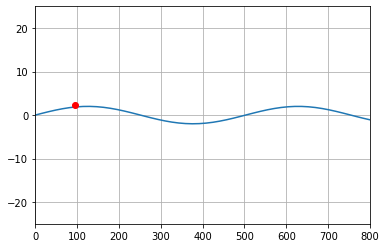

In [2]:
# make the path
xs = np.linspace(0.0,800.0,50)
ys = 2.0*np.sin(xs/80.0)
pnts = np.vstack((xs,ys))

car = pnts[:,6] + np.array((-3.5,0.5))

plt.plot(xs,ys)
plt.grid()
plt.axis([0, 800, -25, 25])
plt.plot(car[0], car[1], 'ro')

In [3]:
# make path segment class

class PathSegment:
    us = np.zeros((2,1)) # unit vector in global frame
    l = 0.0 # length in meters
    speed = 20.0 # speed in meters/sec 2.0 m/s ~= 4.5 mph
    grad = 0.0 # gradient total, used to get max speed
    p0 = np.zeros((2,1)) # starting point
    dt = 0.0 # time to cross it
    carrot = np.zeros((2,1))
    dist = 0.0
    
    def __init__(self, index, pnts):
        self.index = index
        self.p0 = pnts[:,index]
        p1 = pnts[:,index+1]
        self.l = np.linalg.norm(p1-self.p0)
        self.us = (p1 - self.p0) / self.l
        self.dt = self.l / self.speed
        self.carrot = pnts[:,index]
        
    def cout(self):
        print("****************")
        print("index: ", self.index)
        print("p0: ", self.p0)
        print("carrot: ", self.carrot)
        print("us: ", self.us)
        print("dist: ", dist)
        print("l: ", self.l)
        print("speed: ", self.speed)
        print("dt: ", self.dt)
        print("gT: ", self.grad)
        
    def computeGradient(self, pm1, pp1):
        if pm1 == None:
            # starting point
            self.grad = np.linalg.norm(pp1.us - self.us)
            #print("Starting Grad[", self.index, "]: ", self.grad)
            self.speed = self.speed / 2.0
        elif pp1 == None:
            # ending point - goal should be to have V = 0.0
            self.grad = np.linalg.norm(self.us - pm1.us)
            self.speed = self.speed / 2.0
            #print("Ending Grad[", self.index, "]: ", self.grad)
        else:
            # mid point
            self.grad = np.linalg.norm(pp1.us - pm1.us)
            self.speed / 2.0
            #print("Mid Grad[", self.index, "]: ", self.grad)
        
        # set speed
        self.speed = min(self.speed, self.speed / self.grad)
        self.dt = self.l / self.speed
        #print("Speed[",i,"]: ", self.speed)        
    
    def computeSpeed(self, sm1, sp1):
        flag = 0
        # make sure I am not deccelerating too much
        if self.speed > sp1 * 1.1:
            self.speed = sp1 * 1.1
            #print("Speed[",i,"]: ", self.speed)
            flag = 1.0
        # make sure I am not accelerating too
        if self.speed > sm1 * 1.5:
            self.speed = sm1 * 1.5
            flag = 1.0
        # set time to cross
        self.dt = self.l / self.speed
        #print("speed[",i,"]: ", self.speed)
            
        return flag
    
    def propagateCarrot(self, dt):
        # move carrot forward dt
        step = dt*self.speed
        self.dist += step
        if self.dist > self.l:
            # carrot is on next segment, calc how far!
            # print("self.dist - self.l: ", self.dist - self.l)
            dt = (self.dist - self.l) / self.speed
            return [np.zeros((2,1)), dt]
        # carrot is on this segment
        self.carrot = self.p0 + self.dist * self.us
        return [self.carrot, 0]
        
        
            

In [4]:
# make path
path = []
for i in range(pnts.shape[1]-1):
    p = PathSegment(i, pnts)
    #p.cout()
    path.append(p)
    
print("N Path Segments: ", len(path))

# get gradient of direction change across path
path[0].computeGradient(None, path[1])
path[-1].computeGradient(path[-2], None)
for i in range(1,len(path)-1):
    path[i].computeGradient(path[i-1], path[i+1])

# iterative process of refining path speed
# you shouldn't go faster than the next path will want you to
flag = 1
while flag > 0:
    # iterate over each segement, if the next segment is moving slower than this one by X, slow down
    flag = 0
    for i in range(1,len(path)-1):
        flag += path[i].computeSpeed(path[i-1].speed, path[i+1].speed)

N Path Segments:  49


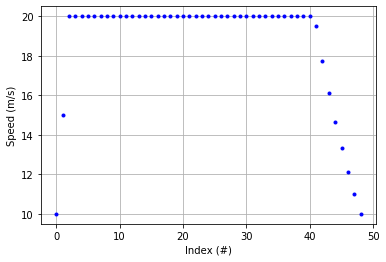

In [5]:
# plot speeds
speeds = []
for p in path:
    speeds.append(p.speed)
    
plt.plot(speeds,'b.')
plt.grid()
plt.ylabel('Speed (m/s)')
plt.xlabel('Index (#)')
plt.show()

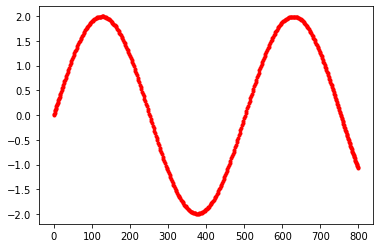

In [6]:
# test propagating the carrot
path_index = 0
carrots = [path[0].p0]
while path_index < len(path):
    #print("path_index: ", path_index)
    dt = 1.0/10.0
    while dt > 0 and path_index < len(path):
        #print("dt_0: ", dt)
        [carrot, dt] = path[path_index].propagateCarrot(dt)
        #print("dt_1: ", dt)
        if dt == 0:
            # its on that segment!
            carrots.append(carrot)
        else:
            path_index += 1

#print("carrots: ", carrots)
for carrot in carrots:
    plt.plot(carrot[0],carrot[1],'r.')

In [7]:
sys.path.insert(0, os.path.abspath('./..'))

In [8]:
import jupylet.color

from jupylet.app import App
from jupylet.state import State
from jupylet.label import Label
from jupylet.sprite import Sprite

In [9]:
app = App(width=800, height=800)#log_level=logging.INFO)

In [10]:
background = '#3e32a2'
foreground = '#7c71da'

body_im = np.ones((20, 120)) * 255
wheel_im = np.ones((15,40)) * 255
a2 = np.ones((app.height * 9 // 10, app.width * 9 // 10, 3)) * 255
course_im = np.ones((2,300))*255

body = Sprite(body_im, y=app.height/2, x=app.width/2)
f_wheel = Sprite(wheel_im, y=app.height/2, x=app.width/2+60, color=foreground)
r_wheel = Sprite(wheel_im, y=app.height/2, x=app.width/2-60, color=foreground)
course = Sprite(course_im, y=600,x=400,color='white')
field = Sprite(a2, y=app.height/2, x=app.width/2, color=background)

In [11]:
speed = Label(
    '0', font_size=22, color=foreground, 
    x=100, y=20,
    anchor_y='center', anchor_x='left'
)

steering_angle = Label(
    '0', font_size=22, color=foreground, 
    x=100, y=44, 
    anchor_y='center', anchor_x='left'
)

In [12]:
@app.event
def render(ct, dt):
    
    app.window.clear(color=foreground)
    field.draw()
    course.draw()
    body.draw()
    f_wheel.draw()
    r_wheel.draw()
    speed.draw()
    steering_angle.draw()

In [13]:
state = State( 
    x = 0.0,
    y = app.height / 2,
    
    body_angle = 0.0,
    steering_angle = 0.0,
    
    l = 50.0,
    speed = 0.0,
    
    turn_left = False,
    turn_right = False,

    speed_up = False,
    slow_down = False,
    
    path_index = 0
)

In [14]:
@app.event
def key_event(key, action, modifiers):
        
    keys = app.window.keys
    
    if action == keys.ACTION_PRESS:
        
        if key == keys.LEFT:
            state.turn_left = True

        if key == keys.RIGHT:
            state.turn_right = True

        if key == keys.UP:
            state.speed_up = True

        if key == keys.DOWN:
            state.slow_down = True

    if action == keys.ACTION_RELEASE:
        if key == keys.LEFT:
            state.turn_left = False

        if key == keys.RIGHT:
            state.turn_right = False

        if key == keys.UP:
            state.speed_up = False

        if key == keys.DOWN:
            state.slow_down = False

In [15]:
@app.run_me_every(1/10)
def update_pads(ct, dt):
        
#     if state.turn_right:
#         state.steering_angle = min(3.14159/3.0, state.steering_angle + 0.05)
        
#     if state.turn_left:
#         state.steering_angle = max(-3.14159/3.0, state.steering_angle - 0.05)
        
#     if state.speed_up:
#         state.speed = min(50.0, state.speed + 1.0)
        
#     if state.slow_down:
#         state.speed = max(0.0, state.speed - 1.0)
   
    
    if state.path_index > len(carrots)-1:
        state.speed = 0.0
        state.x = 0.0
        statey = app.height / 2.0
        state.path_index = 0
    else:
        # get carrot
        carrot = carrots[state.path_index]
        state.path_index += 1
        
        # calculate speed
        dx = carrot[0] - state.x
        dy = 0.0#carrot[1] - state.y

        d = np.sqrt(dx**2 + dy**2)

        state.speed = state.speed + 0.1*(dx - 5)
        state.speed = max(0.0, state.speed)
        state.speed = min(50.0, state.speed)

        print("d: ", d)
        print("speed: ", state.speed)
        print("x: ", state.x, ' of ', app.width)
        print("y: ", state.y, ' of ', app.height)

        # calculate steering angle

    
    
    
    vx = state.speed * math.cos(state.body_angle)
    vy = state.speed * math.sin(state.body_angle)
    vt = state.speed / state.l * math.tan(state.steering_angle)
    
    state.x += vx * dt
    state.y += vy * dt
    state.body_angle -= vt * dt
    
    
    body.x = state.x
    body.y = state.y
    body.angle = state.body_angle*180.0/3.14159
    
    r_wheel.x = body.x - 50.0*math.cos(state.body_angle)
    r_wheel.y = body.y - 50.0*math.sin(state.body_angle)
    r_wheel.angle = body.angle
    f_wheel.x = body.x + 50.0*math.cos(state.body_angle)
    f_wheel.y = body.y + 50.0*math.sin(state.body_angle)
    f_wheel.angle = body.angle - state.steering_angle*180/3.14519
    
    body.clip_position(app.width, app.height)
    
    speed.text = str(vt*dt)
    steering_angle.text = str(state.steering_angle*180/3.14159)
    speed.color = 'white'
    steering_angle.color = 'white'
    

In [16]:
@app.run_me
def highlights(ct, dt):
    while True:
        ct, dt = yield 1/24
        speed.color = 'white'
        steering_angle.color = 'white'
        

In [17]:
app.run()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…